In [ ]:
# Code written by: Michael Bramble | michael.s.bramble@jpl.nasa.gov
# unmixing test script for EMIT AMD investigation
# copying process from my past CRISM/VIR studies
# 20240124 - initial version
# 20240212 - finsihed work on initial working version
# 20240604 - cleaned up code and comments for sharing



In [1]:
# import earthaccess
import os
# from osgeo import gdal
import numpy as np
import pandas as pd
import xarray as xr
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt
# import math
# import rasterio as rio
# import holoviews as hv
import hvplot.xarray
# import netCDF4 as nc
import sys
sys.path.append('/Users/bramble/My Drive/_JPL_AMD/EMIT-Data-Resources-main/python/modules/')
from emit_tools import emit_xarray
import emit_tools

In [2]:
# load reflectance image
granule_asset_id = 'EMIT_L2A_RFL_001_20231006T174849_2327912_017.nc'
fp = f'/Users/bramble/Documents/emit/leadville/ref/{granule_asset_id}'
# load data set and remove the bad bands
ds_geo = emit_xarray(fp, ortho=True)
ds_geo['reflectance'].data[:,:,ds_geo['good_wavelengths'].data==0] = np.nan

# as a test, plot spectra taken from the georeferenced image
point = ds_geo.sel(longitude=-106.5,latitude=39,method='nearest')
ds_geo.sel(wavelengths=850, method='nearest').hvplot.image(cmap='viridis', aspect = 'equal', rasterize=True) +\
point.hvplot.line(y='reflectance',x='wavelengths', color='black', frame_width=400).opts(
    title = f'Latitude = {point.latitude.values.round(3)}, Longitude = {point.longitude.values.round(3)}')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


BokehModel(combine_events=True, render_bundle={'docs_json': {'41a234ba-b437-4fd6-a3d6-bee143119ea0': {'version…

Task exception was never retrieved
future: <Task finished name='Task-7' coro=<Callback.process_on_change() done, defined at /Users/bramble/opt/miniconda3/envs/emit/lib/python3.9/site-packages/holoviews/plotting/bokeh/callbacks.py:322> exception=UnsetValueError("figure(id='p1010', ...).inner_height doesn't have a value set")>
Traceback (most recent call last):
  File "/Users/bramble/opt/miniconda3/envs/emit/lib/python3.9/site-packages/holoviews/plotting/bokeh/callbacks.py", line 340, in process_on_change
    msg[attr] = self.resolve_attr_spec(path, cb_obj)
  File "/Users/bramble/opt/miniconda3/envs/emit/lib/python3.9/site-packages/holoviews/plotting/bokeh/callbacks.py", line 248, in resolve_attr_spec
    resolved = getattr(resolved, p, None)
  File "/Users/bramble/opt/miniconda3/envs/emit/lib/python3.9/site-packages/bokeh/core/property/descriptors.py", line 283, in __get__
    raise UnsetValueError(f"{obj}.{self.name} doesn't have a value set")
bokeh.core.property.descriptors.UnsetValue

In [3]:
# SPATIAL SUBSET IMAGE HERE 
# FOR NOW, MANUALLY. IN FUTURE, AUTOMATE

# LEADVILLE
max_lat = 39.3
min_lat = 39.2
max_lon = -106.3
min_lon = -106.2

# simplify the ref band
band = ds_geo.reflectance

# select just the spatial subset around the mine
subset_data = band.sel({'latitude' : slice(max_lat, min_lat),
                      'longitude' : slice(max_lon, min_lon)})

# GET LAT/LON ARRAYS
band_lon =  subset_data['longitude']
band_lat =  subset_data['latitude']

# REPALCE NaNs. Likely not needed in the final version.
subset_data = subset_data.fillna(0)

# # DISPLAY SUBSET DATA
# subset_data.sel(wavelengths=850, method='nearest').hvplot.image(cmap='viridis', frame_width=500, geo=True, tiles='EsriImagery').opts(
#     xlabel=f'{ds_geo.longitude.long_name} ({ds_geo.longitude.units})', ylabel=f'{ds_geo.latitude.long_name} ({ds_geo.latitude.units})')

# PLOT SPECTRUM FROM SPATIAL SUBSET DATA USING INDEXES
subset_data[50,50].hvplot.line(y='reflectance',x='wavelengths', color='black')

:Curve   [wavelengths]   (reflectance)

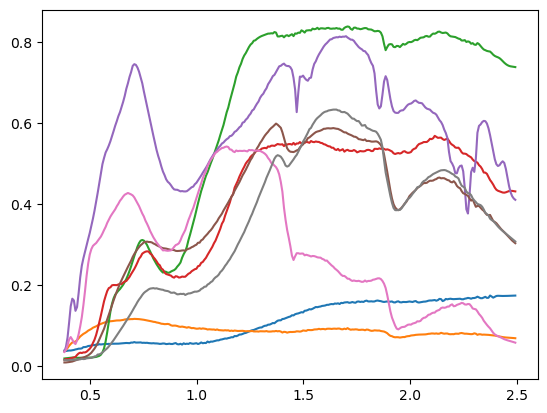

In [4]:
# load wavelenth array
file = '/Users/bramble/My Drive/_JPL_AMD/endmembers/emit_wavelengths.txt'
wavelengths_emit_nm = pd.read_csv(file,header=None)
wavelengths_emit_um = wavelengths_emit_nm[0]/1000

# load endmember library
from script_py_load_amd_endmembers import endmembers
endmember_array = np.arange(1,endmembers.shape[1]+1,1)
endmembers_xr = xr.DataArray(endmembers, coords=[("wavelengths", wavelengths_emit_um), ("endmembers", endmember_array)])
endmembers_xr.name = "reflectance"
# endmembers_xr.hvplot.line(x='wavelengths',y='reflectance')
plt.plot(wavelengths_emit_um,endmembers_xr)


In [ ]:
# print(subset_data.name)
# endmembers_xr.coords

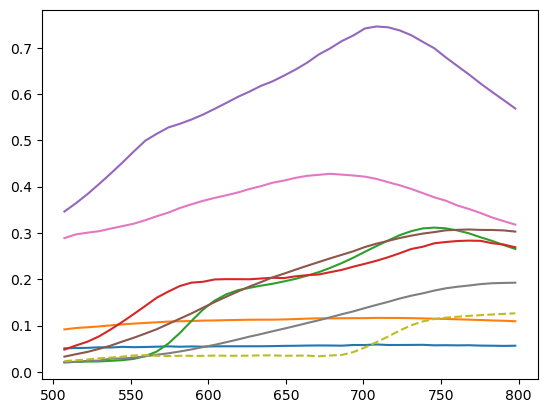

In [5]:
# perform spectral subset on EMIT image and endmember array

subset_data_specsub = subset_data.sel(wavelengths=slice(500, 800))
endmembers_specsub = endmembers_xr.sel(wavelengths=slice(0.5, 0.8))

plt.plot(subset_data_specsub['wavelengths'],endmembers_specsub,subset_data_specsub['wavelengths'],subset_data_specsub[50,50],'--')


In [ ]:
# endmembers_specsub.coords['endmembers']

In [6]:
# begin unmixing process

# newarray = xr.DataArray(None, subset_data.coords, subset_data.dims)
newarray_res_x = xr.DataArray(None, coords=dict(latitude=subset_data_specsub.coords['latitude'],longitude=subset_data_specsub.coords['longitude'],endmembers=endmembers_specsub.coords['endmembers']),dims=[subset_data_specsub.dims[0],subset_data_specsub.dims[1],'endmembers'])
newarray_res_opt = xr.DataArray(None, coords=dict(latitude=subset_data_specsub.coords['latitude'],longitude=subset_data_specsub.coords['longitude']),dims=[subset_data_specsub.dims[0],subset_data_specsub.dims[1]])
for i in np.arange(0,len(band_lon)-1):
    for j in np.arange(0,len(band_lat)-1):
        spectrum = subset_data_specsub[i,j]

        res = lsq_linear(endmembers_specsub, spectrum, bounds=(0, 1), lsmr_tol='auto', verbose=0)

        res.x[res.x < 0.0001] = 0

        newarray_res_x[i,j] = res.x

        newarray_res_opt[i,j] = res.optimality


In [7]:
# VISUALIZE RESULTS

newarray_res_x.sel(endmembers=6,method='nearest').hvplot.image(cmap='viridis',aspect='equal')

# newarray_res_opt.hvplot.image(cmap='viridis',aspect='equal')


# print(newarray_res_x[20,20])
# print(newarray_res_opt[20,20])



:Image   [longitude,latitude]   (value)

In [ ]:
# EXPORT RESULTS - NOT COMPLETED
# write both newarray_res_x and newarray_res_opt to disk

# outpath = '/Users/bramble/Documents/emit/' 
# #  COPY ATTRIBUTES TO OUTPUT FILES
# ds = emit_tools.emit_xarray(fp, ortho=True)
# emit_tools.write_envi(newarray_res_x, outpath, overwrite=False, extension='.img', interleave='BIL', glt_file=False)

